# Pipeline of running CNMF-E 

In [1]:
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
except:
    print('NOT IPYTHON')

import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.widgets import Slider
import caiman as cm
import caiman.source_extraction.cnmf as cnmf

## Step 1: Load data 

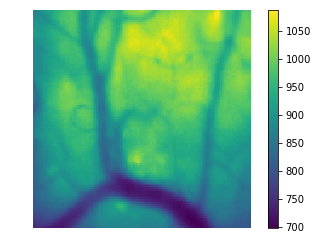

In [2]:
fname = './example_movies/data_endoscope.tif'
Y = cm.load(fname)

# OR load data in GUI mode 
# Y = neuron.ui_get_file()
plt.colorbar(plt.imshow(Y[100,]))
plt.axis('off');

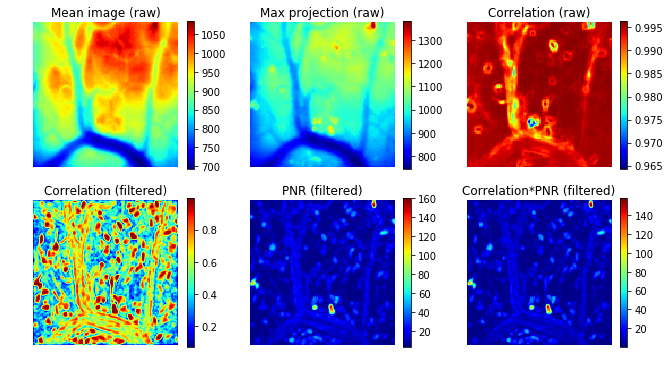

In [3]:
# show correlation image of the raw data; show correlation image and PNR image of the filtered data
cn_raw = cm.summary_images.local_correlation(Y)
cn_filter, pnr, psf = cm.summary_images.correlation_pnr_filtered(Y, gSig=1, gSiz=10, center_psf=True)
plt.figure(figsize=(11, 6))

for i, (data, title) in enumerate(((Y.mean(0), 'Mean image (raw)'),
                                   (Y.max(0), 'Max projection (raw)'),
                                   (cn_raw[1:-1,1:-1], 'Correlation (raw)'),
                                   (cn_filter, 'Correlation (filtered)'),
                                   (pnr, 'PNR (filtered)'),
                                   (cn_filter*pnr, 'Correlation*PNR (filtered)'))):
    plt.subplot(2,3,1+i)
    plt.imshow(data, cmap='jet', aspect='equal')
    plt.axis('off')
    plt.colorbar() 
    plt.title(title);

 # Step 2: initialize

<IPython.core.display.Javascript object>


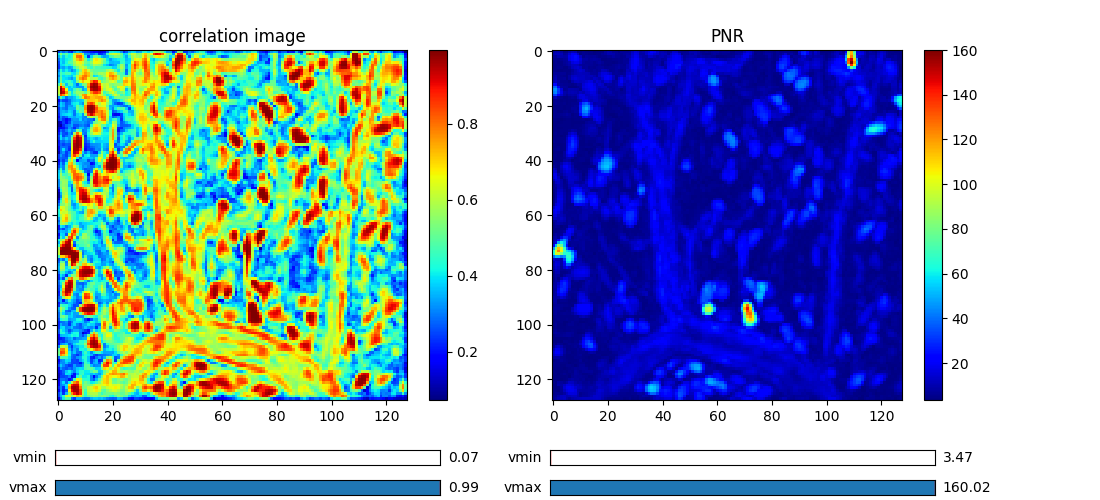

0

In [4]:
# pick thresholds 
%matplotlib notebook
fig = plt.figure(figsize=(11, 5))
plt.axes([0.05, 0.2, 0.4, 0.7])
im_cn = plt.imshow(cn_filter, cmap='jet')
plt.title('correlation image')
plt.colorbar()
plt.axes([0.5, 0.2, 0.4, 0.7])
im_pnr = plt.imshow(pnr, cmap='jet')
plt.title('PNR')
plt.colorbar();

s_cn_max = Slider(plt.axes([0.05, 0.01, 0.35, 0.03]), 'vmax', cn_filter.min(), cn_filter.max(), valinit=cn_filter.max())
s_cn_min = Slider(plt.axes([0.05, 0.07, 0.35, 0.03]), 'vmin', cn_filter.min(), cn_filter.max(), valinit=cn_filter.min())
s_pnr_max = Slider(plt.axes([0.5, 0.01, 0.35, 0.03]), 'vmax', pnr.min(), pnr.max(), valinit=pnr.max())
s_pnr_min = Slider(plt.axes([0.5, 0.07, 0.35, 0.03]), 'vmin', pnr.min(), pnr.max(), valinit=pnr.min())

def update(val):
    im_cn.set_clim([s_cn_min.val, s_cn_max.val])
    im_pnr.set_clim([s_pnr_min.val, s_pnr_max.val])
    fig.canvas.draw_idle()
s_cn_max.on_changed(update)
s_cn_min.on_changed(update)
s_pnr_max.on_changed(update)
s_pnr_min.on_changed(update)
# 'min_corr=0.85', 'min_pnr=20'

In [49]:
results = cnmf.initialization.initialize_components(Y.transpose(1,2,0), K=None, gSiz=(10, 10), gSig=(3,3), method='corr_pnr', 
                                                    center_psf=True, min_corr=0.85, min_pnr=20, ring_model=True, 
                                                    nb=10, normalize_init=False)

Noise Normalization
Roi Extraction...
None 10 3 True 0.85 20 auto None 3 1 2 1.5 True 10
0 neurons have been initialized
10 neurons have been initialized
20 neurons have been initialized
30 neurons have been initialized
40 neurons have been initialized
50 neurons have been initialized
60 neurons have been initialized
70 neurons have been initialized
80 neurons have been initialized
90 neurons have been initialized
100 neurons have been initialized
110 neurons have been initialized
120 neurons have been initialized
In total,  128 neurons were initialized.


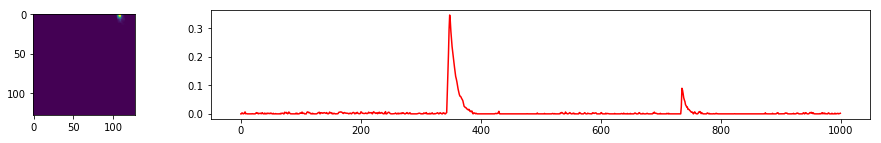

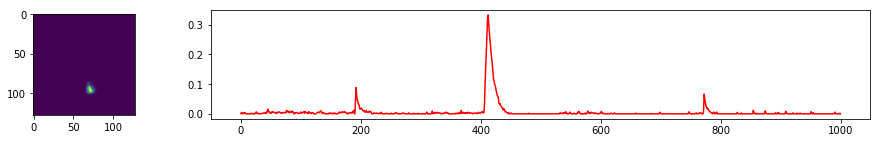

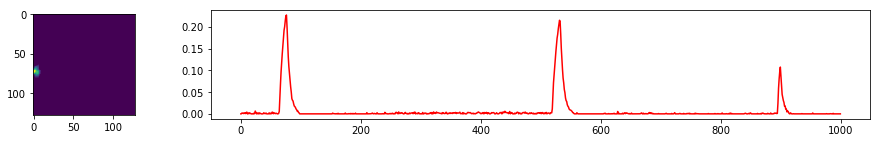

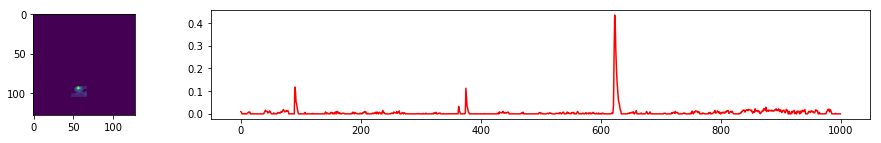

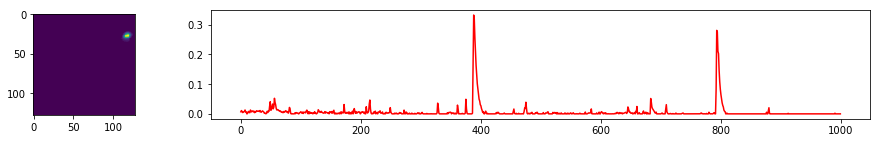

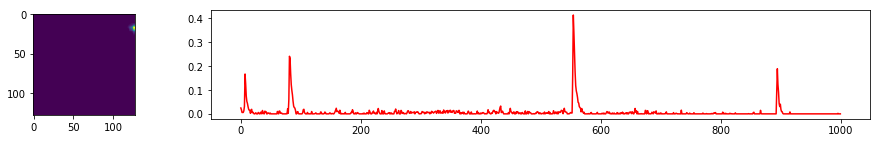

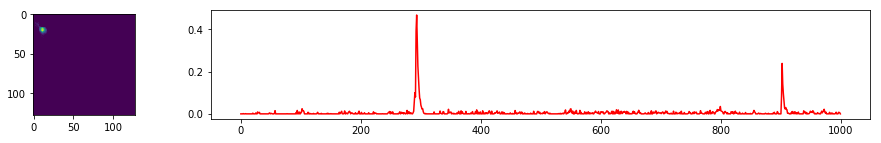

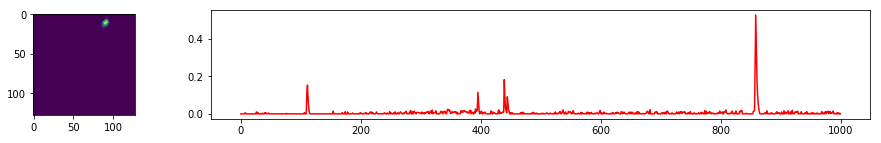

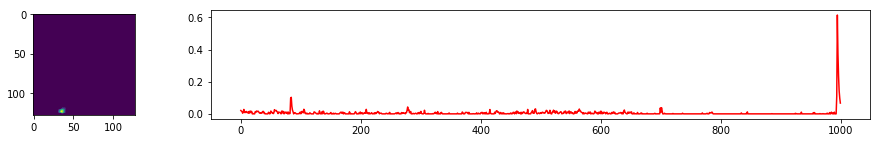

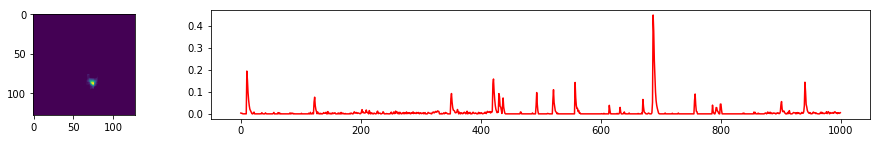

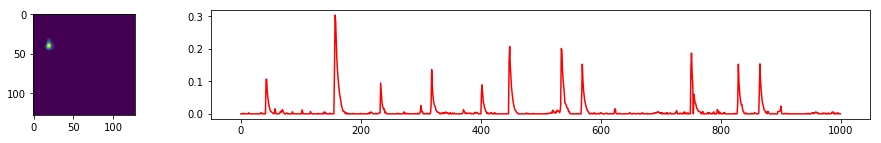

In [50]:
%matplotlib inline
# neurons
for m in range(11):
    f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 6.5]}, figsize=(15,2))
    a0.imshow(results[0][:,m].reshape(Y.shape[1:],order='F'))
    a1.plot(results[1][m], 'r');

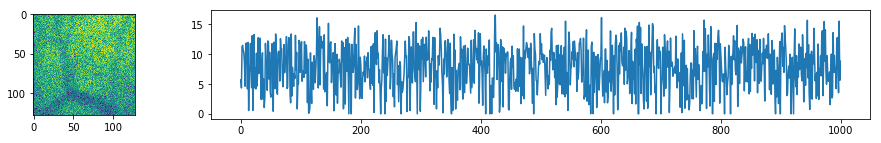

In [7]:
# background components
for m in range(1):
    f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 6.5]}, figsize=(15,2))
    a0.imshow(results[2][:,m].reshape(Y.shape[1:],order='F'))
    a1.plot(results[3][m]);

In [53]:
from scipy.sparse import csc_matrix

In [56]:
cm.utils.visualization.nb_view_patches(Y.reshape(len(Y),-1,order='F').T, csc_matrix(results[0][:,:-1]), results[1][:-1],
                                       results[0][:,-1], results[1][-1],
                                                         Y.shape[1], Y.shape[2], denoised_color='red',
                                                         image_neurons=cn_filter, thr=.9)

array([[  2.37287086,   2.35487812,   2.34011434, ...,   2.29533945,
          2.30950947,   2.29629472],
       [  2.95127712,   2.93225745,   2.90722483, ...,   2.8834763 ,
          2.9149137 ,   2.86243051],
       [  2.35809809,   2.33800309,   2.3235115 , ...,   2.30127193,
          2.31218671,   2.28544954],
       ..., 
       [  7.98600615,   7.93619084,   7.87892162, ...,   7.9293692 ,
          7.99377187,   7.84142192],
       [ 11.21811431,  11.12447741,  11.04453614, ...,  10.94916484,
         10.99984048,  10.87791774],
       [ 34.56915193,  34.41446118,  34.17636472, ...,  33.8786548 ,
         34.25398213,  33.70444507]])

In [57]:
cm.utils.visualization.nb_view_patches(Y.reshape(len(Y),-1,order='F').T, csc_matrix(results[0][:,:-10]), results[1][:-10],
                                       results[0][:,-10:], results[1][-10:],
                                                         Y.shape[1], Y.shape[2], denoised_color='red',
                                                         image_neurons=cn_filter, thr=.9)

array([[  2.37287086,   2.35487812,   2.34011434, ...,   2.29533945,
          2.30950947,   2.29629472],
       [  2.95127712,   2.93225745,   2.90722483, ...,   2.8834763 ,
          2.9149137 ,   2.86243051],
       [  2.35809809,   2.33800309,   2.3235115 , ...,   2.30127193,
          2.31218671,   2.28544954],
       ..., 
       [  7.29687791,   7.20854742,   7.16381286, ...,   7.04426273,
          7.09681057,   7.00528057],
       [ 10.64200257,  10.55658312,  10.5180418 , ...,  10.33693897,
         10.41466576,  10.33804853],
       [  6.55530205,   6.48876649,   6.43770719, ...,   6.40391282,
          6.46881597,   6.37980139]])

In [40]:
# INIT
cnm = cnmf.CNMF(2, method_init='corr_pnr', k=None, gSig=(3,3), merge_thresh=.8,
                p=1, dview=None, tsub=1, ssub=1, Ain=None, method_deconvolution='oasis', 
                low_rank_background=False, update_background_components=False)

In [41]:
cnm.options['init_params']['gSiz'] = (10, 10)
cnm.options['init_params']['gSig'] = (3, 3)
cnm.options['init_params']['min_corr'] = .85
cnm.options['init_params']['min_pnr'] = 20
cnm.options['init_params']['nb'] = 10
cnm.options['init_params']['normalize_init']=False

# Step 3: run CNMF


In [42]:
memmap = False
if memmap:
    fname_new = cm.save_memmap([fname], base_name='Yr')
    Yr, dims, T = cm.load_memmap(fname_new)
    cnm.fit(Yr.T.reshape((T,) + dims, order='F'))
else:
    cnm.fit(Y)

(1000, 128, 128)
using 2 processes
using 4000 pixels per process
using 20000 block_size
preprocessing ...
checking if missing data
Single Thread
4000
4000
4000
4000
384
initializing ...
{'nIter': 5, 'alpha_snmf': 1000.0, 'normalize_init': False, 'max_iter_snmf': 500, 'ssub': 1, 'kernel': None, 'min_corr': 0.85, 'K': None, 'min_pnr': 20, 'tsub': 1, 'gSiz': (10, 10), 'nb': 10, 'gSig': (3, 3), 'maxIter': 5, 'perc_baseline_snmf': 20, 'method': 'corr_pnr', 'sigma_smooth_snmf': (0.5, 0.5, 0.5), 'options_local_NMF': None}
Noise Normalization
Roi Extraction...
None 10 3 True 0.85 20 auto None 3 1 2 1.5 True 10
0 neurons have been initialized
10 neurons have been initialized
20 neurons have been initialized
30 neurons have been initialized
40 neurons have been initialized
50 neurons have been initialized
60 neurons have been initialized
70 neurons have been initialized
80 neurons have been initialized
90 neurons have been initialized
100 neurons have been initialized
110 neurons have been initi

# Step 4: Visualize results


In [45]:
cm.utils.visualization.nb_view_patches?

In [48]:
from bokeh.io import output_notebook, reset_output
output_notebook()  # create output within this notebook
# reset_output()  # default creates output in seperate html file
if memmap:
    traces_fluo = cm.utils.visualization.nb_view_patches(Yr, cnm.A, cnm.C, cnm.b, cnm.f, 
                                                         dims[0],dims[1], denoised_color='red',
                                                         image_neurons=cn_filter)
else:
    traces_fluo = cm.utils.visualization.nb_view_patches(Y.reshape(len(Y),-1,order='F').T, cnm.A, cnm.C, cnm.b, cnm.f,
                                                         Y.shape[1], Y.shape[2], denoised_color='red',
                                                         image_neurons=cn_filter, thr=.9)

Loading BokehJS ...